In [32]:
import spacy
from spacy.training import Example
from sklearn.model_selection import train_test_split
from spacy.util import minibatch  # Import minibatch

# Načtení základního modelu
nlp = spacy.blank("cs")

# Přidání pipeline komponenty NER
ner = nlp.add_pipe("ner")

In [9]:
TRAINING_DATA = [
    ("Vinařství Adámkovi J. a A. barva červená víno Chrupka ročník 2022 hodnocení 85", {
        "entities": [
            (11, 23, "Winery"),  # Adámkovi J. a A.
            (30, 37, "Color"),  # červená
            (43, 50, "Wine"),  # Chrupka
            (59, 63, "Year"),  # 2022
            (74, 76, "Rating")  # 85
        ]
    }),
    ("Vinařství Charvát Zdeněk barva vína bílá víno Chardonnay rok 2024 body 87", {
        "entities": [
            (11, 22, "Winery"),  # Charvát Zdeněk
            (29, 34, "Color"),  # bílá
            (40, 50, "Wine"),  # Chardonnay
            (55, 59, "Year"),  # 2024
            (65, 67, "Rating")  # 87
        ]
    }),
    ("barva vína bílá víno Ryzlink rýnský Vinařství Buchtík Zdeněk rok 2023 hodnocení 86", {
        "entities": [
            (12, 17, "Color"),  # bílá
            (23, 39, "Wine"),  # Ryzlink rýnský
            (50, 62, "Winery"),  # Buchtík Zdeněk
            (67, 71, "Year"),  # 2023
            (82, 84, "Rating")  # 86
        ]
    })
]


In [33]:
import json

# Step 2: Open the JSON file
with open('generated_train_data/ner_tagged_sentences.json', 'r', encoding='utf-8') as file:
    # Step 3: Load the JSON data
    data = json.load(file)
TRAINING_DATA2 = []
ner_labels = data["classes"]
for item in data["annotations"]:
    text = item[0].strip()  # Get the text and strip any extra whitespace
    entities = item[1]["entities"]
    
    # Create a dictionary for the current sentence's entities
    entities_formatted = {"entities": [(start, end, label) for start, end, label in entities]}
    
    # Append the tuple (text, entities) to the training data
    TRAINING_DATA2.append((text, entities_formatted))

print(TRAINING_DATA2)

[('vinařství Hrdlička Miloslav víno Veltlínské zelené ročník 2023 hodnocení 86 barva růžová polosladké', {'entities': [(10, 27, 'VINAŘSTVÍ'), (33, 50, 'VÍNO'), (58, 62, 'ROČNÍK'), (73, 75, 'HODNOCENÍ'), (82, 88, 'BARVA'), (89, 99, 'SLADKOST')]}), ('ročníku 2022 vinařství Vinařství u Stehlíků odrůda Rulandské bílé polosladké barva bílá body 71', {'entities': [(8, 12, 'ROČNÍK'), (23, 43, 'VINAŘSTVÍ'), (51, 65, 'VÍNO'), (66, 76, 'SLADKOST'), (83, 87, 'BARVA'), (93, 95, 'HODNOCENÍ')]}), ('vinař Janda Lubomír ročníku 2022 polosuché body 82 víno Hibernal barvy bílá', {'entities': [(6, 19, 'VINAŘSTVÍ'), (28, 32, 'ROČNÍK'), (33, 42, 'SLADKOST'), (48, 50, 'HODNOCENÍ'), (56, 64, 'VÍNO'), (71, 75, 'BARVA')]}), ('bílá body 71 vinař Vinařství Košulič rok 2023 sladkost sladké víno Svatovavřinecké', {'entities': [(0, 4, 'BARVA'), (10, 12, 'HODNOCENÍ'), (19, 36, 'VINAŘSTVÍ'), (41, 45, 'ROČNÍK'), (55, 61, 'SLADKOST'), (67, 82, 'VÍNO')]}), ('bílá vinařství Ondrouch Martin víno Muškát moravský polosladké

In [34]:
# Přidání labelů do NER
print(ner_labels)
for label in ner_labels:
    ner.add_label(label)
    # for ent in annotations.get("entities"):
    #     print(ent[2])
        # ner.add_label(ent[2])

['VINAŘSTVÍ', 'BARVA', 'ROČNÍK', 'HODNOCENÍ', 'VÍNO', 'SLADKOST']


In [35]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(TRAINING_DATA2, test_size=0.2, random_state=42)

In [ ]:
# Helper function to train the model
import random

def train_spacy_model(train_data, n_iter=10):
    optimizer = nlp.begin_training()
    
    for i in range(n_iter):
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=8)
        for batch in batches:
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update([example], drop=0.5, sgd=optimizer, losses=losses)
        print(f"Iteration {i+1}, Loss: {losses['ner']}")
    
    return nlp

# Začátek tréninku
# optimizer = nlp.begin_training()

# # Trénovací smyčka
# for i in range(10):  # Trénuj 10 epoch
#     for text, annotations in TRAINING_DATA2:
#         example = Example.from_dict(nlp.make_doc(text), annotations)
#         nlp.update([example], sgd=optimizer)

In [37]:
# Train the model
trained_nlp = train_spacy_model(train_data)
print(trained_nlp)
trained_nlp.to_disk("models/wine_ner_model")

odrůda Tramín červený barva růžové hodnocení 82 sladké ročník 2023 vinař Víno Pokorný {'entities': [(7, 21, 'VÍNO'), (28, 34, 'BARVA'), (45, 47, 'HODNOCENÍ'), (48, 54, 'SLADKOST'), (62, 66, 'ROČNÍK'), (73, 85, 'VINAŘSTVÍ')]}
body 86 barvy červená víno Dornfelder ročník 2022 vinařství Vinařství u Stehlíků sladkost suché {'entities': [(5, 7, 'HODNOCENÍ'), (14, 21, 'BARVA'), (27, 37, 'VÍNO'), (45, 49, 'ROČNÍK'), (60, 80, 'VINAŘSTVÍ'), (90, 95, 'SLADKOST')]}
sladkost polosuché víno Hibernal vinařství Paulík Josef bílá ročníku 2022 body 87 {'entities': [(9, 18, 'SLADKOST'), (24, 32, 'VÍNO'), (43, 55, 'VINAŘSTVÍ'), (56, 60, 'BARVA'), (69, 73, 'ROČNÍK'), (79, 81, 'HODNOCENÍ')]}
vinařství Švehlík Zbyněk víno Dornfelder rok 2022 body 84 barvy červené sladké {'entities': [(10, 24, 'VINAŘSTVÍ'), (30, 40, 'VÍNO'), (45, 49, 'ROČNÍK'), (55, 57, 'HODNOCENÍ'), (64, 71, 'BARVA'), (72, 78, 'SLADKOST')]}
sladké hodnocení 78 barva růžové rok 2021 odrůda Ryzlink vlašský vinařství Vinařství Tomčala {'entiti

KeyboardInterrupt: 

In [13]:
test_sentences = [
    "Vinařství Adámkovi J. a A. barva červená víno Chrupka ročník 2022 hodnocení 85",
    "Vinařství Charvát Zdeněk barva vína bílá víno Chardonnay rok 2024 body 87",
    "barva vína bílá víno Ryzlink rýnský Vinařství Buchtík Zdeněk rok 2023 hodnocení 86",
    "Vinařství Turčínek Pavel bílá vino Hibernal ročník 2020 hodnocení 85",
]

In [7]:
import matplotlib.pyplot as plt
from spacy.scorer import Scorer

# Evaluate the model
def evaluate_model(nlp, test_data):
    examples = []
    for text, annotations in test_data:
        doc = nlp(text)
        example = Example.from_dict(doc, annotations)
        examples.append(example)
    
    # Scorer method expects a list of examples
    scores = nlp.evaluate(examples)
    return scores

In [15]:
# Get the evaluation metrics
scores = evaluate_model(trained_nlp, test_data)

# Extract precision, recall, and F1-score
precision = scores["ents_p"]
recall = scores["ents_r"]
f_score = scores["ents_f"]

print(precision)

0.99


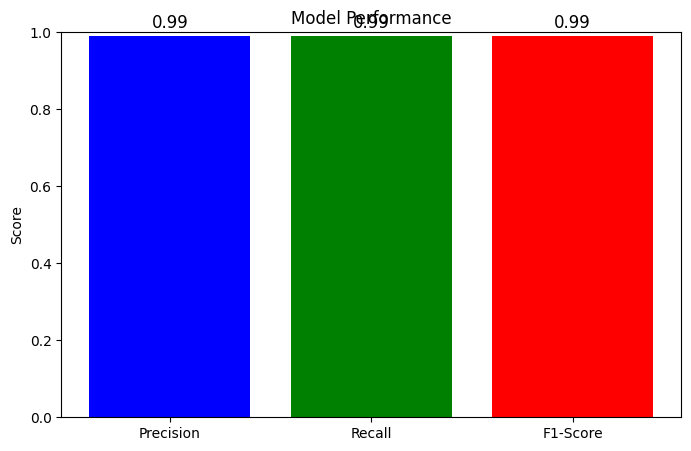

In [9]:
# Plot the results
def plot_metrics(precision, recall, f_score):
    metrics = ["Precision", "Recall", "F1-Score"]
    scores = [precision, recall, f_score]
    
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, scores, color=['blue', 'green', 'red'])
    plt.ylim([0, 1])
    plt.title("Model Performance")
    plt.ylabel("Score")
    for i, score in enumerate(scores):
        plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=12)
    plt.show()

# Plot the performance metrics
plot_metrics(precision, recall, f_score)

In [16]:
for sentence in test_sentences:
    doc = nlp(sentence)
    print(f"Test sentence: {sentence}")
    for ent in doc.ents:
        print(f"Entity: {ent.text}, Label: {ent.label_}")
    print()

Test sentence: Vinařství Adámkovi J. a A. barva červená víno Chrupka ročník 2022 hodnocení 85
Entity: Vinařství Adámkovi J. a A., Label: VINAŘSTVÍ
Entity: červená, Label: BARVA
Entity: Chrupka, Label: VÍNO
Entity: 2022, Label: ROČNÍK
Entity: 85, Label: HODNOCENÍ

Test sentence: Vinařství Charvát Zdeněk barva vína bílá víno Chardonnay rok 2024 body 87
Entity: Vinařství Charvát Zdeněk, Label: VINAŘSTVÍ
Entity: bílá, Label: BARVA
Entity: Chardonnay, Label: VÍNO
Entity: 2024, Label: ROČNÍK
Entity: 87, Label: HODNOCENÍ

Test sentence: barva vína bílá víno Ryzlink rýnský Vinařství Buchtík Zdeněk rok 2023 hodnocení 86
Entity: bílá, Label: BARVA
Entity: Ryzlink rýnský, Label: VÍNO
Entity: Vinařství Buchtík Zdeněk, Label: VINAŘSTVÍ
Entity: 2023, Label: ROČNÍK
Entity: 86, Label: HODNOCENÍ

Test sentence: Vinařství Turčínek Pavel bílá vino Hibernal ročník 2020 hodnocení 85
Entity: Vinařství Turčínek Pavel, Label: VINAŘSTVÍ
Entity: bílá, Label: BARVA
Entity: Hibernal, Label: VÍNO
Entity: 2020, Lab